In [1]:
import jax # type: ignore
from jax import numpy as jnp # type: ignore
from jax import random as jr # type: ignore
from jax import vmap # type: ignore
from jax.tree_util import tree_flatten
from jax.flatten_util import ravel_pytree
from flax import nnx # type: ignore

from utils import reshape_emissions
from density_models import MAF
from parameters import params_from_tree, sample_ssm_params, initialize
import tensorflow_probability.substrates.jax.distributions as tfd # type: ignore
import tensorflow_probability.substrates.jax.bijectors as tfb
from simulation_inference import sample_and_train
from ssm import LGSSM
from filters import bpf
from output_utils import to_dynamax_params, logdensity_fn, loglik, true_loglik, smc_sampler

from dynamax.utils.plotting import plot_uncertainty_ellipses # type: ignore
from dynamax.linear_gaussian_ssm.models import LinearGaussianSSM # type: ignore
from dynamax.linear_gaussian_ssm.inference import ParamsLGSSMInitial, ParamsLGSSMDynamics, ParamsLGSSMEmissions, ParamsLGSSM, lgssm_smoother, lgssm_filter # type: ignore
from dynamax.utils.bijectors import RealToPSDBijector # type: ignore
from dynamax.parameters import to_unconstrained, from_unconstrained, log_det_jac_constrain, ParameterProperties # type: ignore

import scienceplots
import matplotlib.pyplot as plt
import matplotlib_inline

plt.style.use(['science', 'ieee'])
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## Setup

### SSM parameters

In [ ]:
num_timesteps = 100 # Number of emissions timesteps
num_particles = 1000 # Number of particles for BPF

state_dim = 4
emission_dim = 1
input_dim = 0

initial_mean = jnp.zeros(state_dim)
initial_covariance = jnp.eye(state_dim) * 0.1

dynamics_weights  = 0.9 * jnp.eye(state_dim)
dynamics_bias = jnp.zeros(state_dim)
dynamics_input_weights = jnp.zeros((state_dim, input_dim))
dynamics_covariance = jnp.eye(state_dim) * 0.1

emission_weights = jnp.eye(emission_dim, state_dim)
emission_bias = jnp.zeros(emission_dim)
emission_input_weights = jnp.zeros((emission_dim, input_dim))
emission_covariance = jnp.eye(emission_dim) * 0.1

# Initialize params and props
m = state_dim * (state_dim + 1) // 2
dynamics_covariance_dist = tfd.MultivariateNormalDiag(loc=jnp.zeros(m), scale_diag=0.1*jnp.ones(m))

param_names = [['mean', 'cov'],
               ['weights', 'bias', 'input_weights', 'cov'],
               ['weights', 'bias', 'input_weights', 'cov']]

prior_fields = [[initial_mean, initial_covariance],
                [dynamics_weights, dynamics_bias, dynamics_input_weights, dynamics_covariance_dist],
                [emission_weights, emission_bias, emission_input_weights, emission_covariance]]

is_constrained_tree = [[True, True], 
                       [True, True, True, False], 
                       [True, True, True, True]]

constrainers  = [[None, RealToPSDBijector],
                [None, None, None, RealToPSDBijector],
                [None, None, None, RealToPSDBijector]]

props, prior = initialize(prior_fields, param_names, constrainers)

### Sample emissions and states

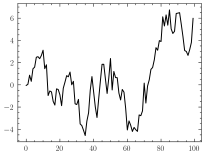

In [3]:
key, subkey = jr.split(jr.PRNGKey(315520))
true_lgssm = LGSSM(state_dim, emission_dim)
[true_params, example_param] = sample_ssm_params(key, prior, 2)
true_params.from_unconstrained(props)
states, emissions = true_lgssm.simulate(subkey, true_params, num_timesteps)

plt.plot(emissions)
plt.show()

## Inference

### Likelihood approximation

In [4]:
# covs = []
# params_list = []
# for param in sample_ssm_params(key, prior, 100):
#     param.from_unconstrained(props)
#     params_list.append(param)
#     covs.append(param.dynamics.cov.value)
# thetas = jnp.array(covs).flatten()
# # thetas = jnp.sort(thetas)
# # BPF
# num_particles = 1000
# num_iters = 1
# lls = []
# for param in params_list:
#     ll = 0
#     for _ in range(num_iters):
#         _, ll_i = bpf(param, true_lgssm, emissions, num_particles, key)
#         ll += ll_i/num_iters 
#     lls.append(ll)
# lls = jnp.array(lls)
# # plt.scatter(thetas, lls)
# # plt.show()

### Posterior sampling with BlackJax

In [ ]:
import blackjax
from datetime import date
from parameters import log_prior, get_unravel_fn, join_trees, tree_from_params, to_train_array

# Define test-model (SSM) and log-density function
lgssm = LGSSM(state_dim, emission_dim)

def logdensity_fn(cond_params):
    unravel_fn = get_unravel_fn(example_param, props)
    unravel = unravel_fn(cond_params)
    tree = tree_from_params(example_param)
    new_tree = join_trees(unravel, tree, props)
    params = params_from_tree(new_tree, param_names, is_constrained_tree)
    params.from_unconstrained(props)
    _, lp = bpf(params, lgssm, emissions, num_particles, key)
    lp += log_prior(cond_params, prior)
    return jnp.mean(lp)

# Initialize MCMC chain and kernel
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))
initial_cond_params = to_train_array(sample_ssm_params(rng_key, prior, 1)[0], props)
random_walk = blackjax.additive_step_random_walk(logdensity_fn, blackjax.mcmc.random_walk.normal(0.1))
initial_state = random_walk.init(initial_cond_params)
kernel = jax.jit(random_walk.step)

# Define inference loop
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

# Run inference loop
rng_key, sample_key = jax.random.split(rng_key)
states = inference_loop(sample_key, kernel, initial_state, 2_000)

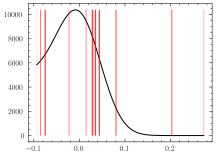

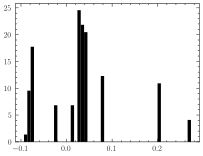

In [ ]:
import jax.scipy.stats as jss
kernel_points = states.position[-100:].T
posterior_mean = jnp.mean(kernel_points, axis=1)
kde = jss.gaussian_kde(kernel_points, bw_method=1.0)
min = jnp.min(kernel_points[0, :])
max = jnp.max(kernel_points[0, :])

eval_points_at_dim = jnp.linspace(min, max, 100)
eval_points = jnp.concatenate([eval_points_at_dim[None].T, jnp.tile(posterior_mean[1:], (100, 1))], axis=1)
density_evals = kde.evaluate(eval_points.T)

plt.plot(eval_points_at_dim, density_evals)
plt.vlines(kernel_points[0, :], jnp.min(density_evals), jnp.max(density_evals), color='red', alpha=0.1)
plt.show()
plt.hist(kernel_points[0, :], bins=50, density=True)
plt.show()
# print(-jnp.log(kde.evaluate(RealToPSDBijector().inverse(true_params.dynamics.cov.value))))

In [22]:
density_evals

Array([5.8423096e+03, 5.9817437e+03, 6.1373965e+03, 6.3097949e+03,
       6.4990176e+03, 6.7046611e+03, 6.9258477e+03, 7.1612319e+03,
       7.4089985e+03, 7.6669111e+03, 7.9323018e+03, 8.2021201e+03,
       8.4729717e+03, 8.7411494e+03, 9.0026865e+03, 9.2534316e+03,
       9.4890928e+03, 9.7053223e+03, 9.8978164e+03, 1.0062386e+04,
       1.0195031e+04, 1.0292100e+04, 1.0350335e+04, 1.0366977e+04,
       1.0339878e+04, 1.0267557e+04, 1.0149262e+04, 9.9850254e+03,
       9.7756758e+03, 9.5228398e+03, 9.2289453e+03, 8.8971221e+03,
       8.5311816e+03, 8.1355049e+03, 7.7149077e+03, 7.2745684e+03,
       6.8198604e+03, 6.3562383e+03, 5.8890854e+03, 5.4235933e+03,
       4.9646631e+03, 4.5167715e+03, 4.0839282e+03, 3.6695786e+03,
       3.2765825e+03, 2.9071860e+03, 2.5630293e+03, 2.2451545e+03,
       1.9540427e+03, 1.6896812e+03, 1.4515848e+03, 1.2389003e+03,
       1.0504485e+03, 8.8480353e+02, 7.4036096e+02, 6.1539722e+02,
       5.0812955e+02, 4.1676669e+02, 3.3955042e+02, 2.7479050e